In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import unicodedata
import string
import re
import random
import os
import librosa
import pickle
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import math
import librosa.display
import numpy as np

print(torch.__version__)
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

1.5.0+cpu
cpu


In [2]:
'''
Summary:
    将音乐转换为note
Parameters:
    data - libsora读取到的y
    rate - libsora读取到的rate
Return:
    Note - note列表
'''
def music2note(data,rate):
    #转置 降噪
    data=np.transpose(data)
    data=data/data.max()
    data[data<0.75]=0

    #单位频率
    unit_rate=rate/(data.shape[1]-1)
    Note=[]

    for i in data:
        note=[]
        for j in range(len(i)):
            #第一个非0值
            if i[j]>0 and len(note)==0:
                #频率转换音符
                note_str = librosa.hz_to_note((j+1)*unit_rate)
                #print(note_str)
                #if 'Db' == note_str[:2]
                if note_str[1] == '#':
                    note_str = note_str[0]+note_str[2]+'#'
                note.append(note_str)
                
        if len(note)!=0:
            Note.append(note[0])
    return  Note

'''
Summary:
    调用该函数返回最终的note列表

Return:
    data - note列表
'''
def ChangeMuisc2Note(filpath):
    y,rate=librosa.load(filpath,44100)
    #短时傅里叶
    fft=librosa.stft(y,n_fft=1024*2)
    #转换为分贝值
    D=librosa.amplitude_to_db(abs(fft),ref=np.max)
    #数据>0
    D=D+80
    
    data=music2note(D,rate/2)

#     output=open('note.txt','w+')
#     for i in range(len(data)):
#         output.write(data[i])
#         output.write('\n')
#     output.close()
    return data



def getData():
    path='wavDatasets//'
    listdir=os.listdir(path)
    data={}
    for x in listdir:
        if 'wav' in x:
            y = ChangeMuisc2Note('wavDatasets//'+x)
            y = one_hot(y)
            #print(y)
            data[x[0:-4]]=y
    return data

def getLabel():
    df=open('wavDatasets//music_dic.pkl','rb')#注意此处是rb
    #此处使用的是load(目标文件)
    music_dic=pickle.load(df)
    df.close()
    label={}
    for x in music_dic.keys():
        y=music_dic[x]
        label[x]=one_hot(y)
    return label

note_label_list = ['<S>','<E>','other','C4','C#4','D4','D#4','E4','F4','F#4',
                   'G4','G#4','A4','A#4','B4','C5','C#5','D5','D#5','E5','F5',
                   'F#5','G5','G#5','A5','A#5','B5','C6','C#6','D6','D#6','E6',
                   'F6','F#6','G6','G#6','A6','A#6','B6','C7','C#7']

#得到note和num字典
def getDict():
    note_dic = {}
    for x in range(len(note_label_list)):
        if note_label_list[x] not in note_dic.keys():
            # onehot = np.zeros(len(note))
            # onehot[x] = 1
            note_dic[note_label_list[x]] = x
    num_dic=dict(zip(note_dic.values(),note_dic.keys()))

    return note_dic,num_dic

note_dic,num_dic = getDict()

def one_hot(y):
    note=[]
    note.append(note_dic['<S>'])
    for x in y:
        try:
            note.append(note_dic[x])
        except:
            note.append(note_dic['other'])
    note.append(note_dic['<E>'])
    return note

#会调用前面的函数，最后返回训练集的数据
#形状为（x_train,y_train)，x_train是训练集音频数据，y_train是训练集数据标签
#数据类型均为torch.longtensor
def getPair():
    x=getData()
    #print(x)
    y=getLabel()
    data=[]
    label=[]
    for key in x.keys():
        a=x[key]
        a=list(a)
        #print(a)
        a=torch.Tensor(a).view(len(a),1).long()
        b=torch.Tensor(y[key]).view(len(y[key]),1).long()
        a = a.to(device)
        #print(a)
        b = b.to(device)
        data.append(a)
        label.append(b)
    return data,label

In [3]:
#获取数据和字典
x,y = getPair()
MAX_LENGTH = max([i.shape[0] for i in x])
S_token=0#代表句子的开始
E_token=1#代表句子的结束
print(len(x),len(y))

150 150


In [15]:
print(x[-1].size())

torch.Size([434, 1])


In [4]:
#保存训练数据
file=open('x.pkl','wb')
pickle.dump(x,file)
file.close()

D:\ProgramData\Anaconda3\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [6]:
#保存标签数据
file=open('y.pkl','wb')
pickle.dump(y,file)
file.close()

In [16]:
#读取训练数据和标签数据
file=open('x.pkl','rb')
x=pickle.load(file)
file.close()
file=open('y.pkl','rb')
y=pickle.load(file)
file.close()

MAX_LENGTH = max([i.shape[0] for i in x])
S_token=0#代表句子的开始
E_token=1#代表句子的结束

In [17]:
#分开训练数据和测试数据
x_train=x[0:100]
y_train=y[0:100]
x_test=x[100:-1]
y_test=y[100:-1]

In [18]:
print(x_test[0].size())
print(MAX_LENGTH)

torch.Size([911, 1])
1289


In [19]:
#不要动它
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#不要动它
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length=max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat([embedded[0], hidden[0]], 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat([embedded[0], attn_applied[0]], 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#不要动它
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,maxlen=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(maxlen, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_input = torch.tensor([[S_token]], device=device)

    decoder_hidden = encoder_hidden
    teacher_forcing_ratio=0.5
    use_teacher_forcing = False#True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the targer as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing


    else:
        # Without teaching forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == E_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length,encoder,decoder

#不要动它
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#不要动它
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [34]:
#encoder和decoder是模型
#epochs是训练迭代次数
#n_iters是训练模型时需要训练的数据个数（一般情况下时训练集数据的个数），该参数不可以大于训练集数据的个数
#print_every是每训练多少个数据打印一次loss信息
#plot_every是每训练多少个数据记录一次loss信息并在最后可视化
#save_every是每迭代多少次保存一次模型和相关的loss信息
#n_trains是第几次训练
def trainIters(encoder, decoder, n_iters, print_every=1, plot_every=1,save_every=1, learning_rate=0.01,epochs=10,n_trains=1):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()
    epochs=epochs+1
    for epoch in range(1,epochs):
        print('epoch:',epoch)
        for iter in range(1, n_iters + 1):
            print('iter:',iter)
            input_tensor = x_train[iter-1]
            target_tensor = y_train[iter-1]
            print('input_tensor:',input_tensor.size())
            print('target_tensor:',target_tensor.size())

            loss,encoder,decoder= train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

            print_loss_total += loss
            plot_loss_total += loss
            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg))
                                       

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                
        if epoch % save_every==0:
            torch.save(encoder,'model/ecnoder{}.pkl'.format(str(epoch)+'-'+str(n_trains)+'次训练'))
            torch.save(decoder,'model/attn_decoder{}.pkl'.format(str(epoch)+'-'+str(n_trains)+'次训练'))
            loss=np.array(plot_losses)
            np.save('Loss/loss{}.npy'.format(str(epoch)),loss)
                
    showPlot(plot_losses)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#不要动它
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    


#不要动它
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = sentence
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[S_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
#             print(topi.item())
            if topi.item() == E_token:
#                 print('<E>')
                decoded_words.append('<E>')
                break
            else:
                # print(di,num_dic[topi.item()])
                decoded_words.append(num_dic[topi.item()])


            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#x_test是测试音频数据
#y_test是测试数据标签
#n是测试数据的数量
def evaluateRandomly(encoder, decoder, x_test,y_test=None,n=1):
    for i in range(n):
        print('>', x_test[i].size())
        print('=', y_test[i].size())
        output_words, attentions = evaluate(encoder, decoder, x_test[i])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        return output_words

In [21]:
hidden_size = 64
dic_size = len(note_label_list)

# 第一个参数是字典大小
encoder1 = EncoderRNN(dic_size, hidden_size).to(device)
#第二个参数是字典大小
attn_decoder1 = AttnDecoderRNN(hidden_size, dic_size, dropout_p=0.1).to(device)

In [10]:
print(dic_size)

41


In [17]:
encoder1

EncoderRNN(
  (embedding): Embedding(41, 64)
  (gru): GRU(64, 64)
)

In [18]:
attn_decoder1

AttnDecoderRNN(
  (embedding): Embedding(41, 64)
  (attn): Linear(in_features=128, out_features=1289, bias=True)
  (attn_combine): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(64, 64)
  (out): Linear(in_features=64, out_features=41, bias=True)
)

epoch: 1
iter: 1
input_tensor: torch.Size([432, 1])
target_tensor: torch.Size([12, 1])
0m 0s (- 0m 29s) (1 1%) 3.7574
iter: 2
input_tensor: torch.Size([1200, 1])
target_tensor: torch.Size([30, 1])
0m 1s (- 0m 50s) (2 2%) 0.7467
iter: 3
input_tensor: torch.Size([1037, 1])
target_tensor: torch.Size([26, 1])
0m 1s (- 0m 54s) (3 3%) 1.3077
iter: 4
input_tensor: torch.Size([1203, 1])
target_tensor: torch.Size([30, 1])
0m 2s (- 0m 58s) (4 4%) 0.4877
iter: 5
input_tensor: torch.Size([524, 1])
target_tensor: torch.Size([14, 1])
0m 2s (- 0m 52s) (5 5%) 3.6334
iter: 6
input_tensor: torch.Size([693, 1])
target_tensor: torch.Size([18, 1])
0m 3s (- 0m 51s) (6 6%) 3.5578
iter: 7
input_tensor: torch.Size([692, 1])
target_tensor: torch.Size([18, 1])
0m 3s (- 0m 49s) (7 7%) 1.7599
iter: 8
input_tensor: torch.Size([828, 1])
target_tensor: torch.Size([21, 1])
0m 4s (- 0m 49s) (8 8%) 3.6184
iter: 9
input_tensor: torch.Size([689, 1])
target_tensor: torch.Size([18, 1])
0m 4s (- 0m 48s) (9 9%) 3.5850
iter: 1

0m 43s (- 0m 16s) (73 73%) 2.7980
iter: 74
input_tensor: torch.Size([1289, 1])
target_tensor: torch.Size([32, 1])
0m 44s (- 0m 15s) (74 74%) 2.6580
iter: 75
input_tensor: torch.Size([1080, 1])
target_tensor: torch.Size([27, 1])
0m 45s (- 0m 15s) (75 75%) 3.0250
iter: 76
input_tensor: torch.Size([908, 1])
target_tensor: torch.Size([23, 1])
0m 45s (- 0m 14s) (76 76%) 2.8482
iter: 77
input_tensor: torch.Size([1077, 1])
target_tensor: torch.Size([27, 1])
0m 46s (- 0m 13s) (77 77%) 2.6412
iter: 78
input_tensor: torch.Size([566, 1])
target_tensor: torch.Size([15, 1])
0m 46s (- 0m 13s) (78 78%) 2.5879
iter: 79
input_tensor: torch.Size([1160, 1])
target_tensor: torch.Size([29, 1])
0m 47s (- 0m 12s) (79 79%) 3.0361
iter: 80
input_tensor: torch.Size([479, 1])
target_tensor: torch.Size([13, 1])
0m 48s (- 0m 12s) (80 80%) 2.8395
iter: 81
input_tensor: torch.Size([1261, 1])
target_tensor: torch.Size([31, 1])
0m 48s (- 0m 11s) (81 81%) 2.5839
iter: 82
input_tensor: torch.Size([480, 1])
target_tensor

D:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0m 59s (- 97m 46s) (1 1%) 2.8094
iter: 2
input_tensor: torch.Size([1200, 1])
target_tensor: torch.Size([30, 1])
1m 0s (- 49m 1s) (2 2%) 2.7182
iter: 3
input_tensor: torch.Size([1037, 1])
target_tensor: torch.Size([26, 1])
1m 0s (- 32m 42s) (3 3%) 2.8141
iter: 4
input_tensor: torch.Size([1203, 1])
target_tensor: torch.Size([30, 1])
1m 1s (- 24m 35s) (4 4%) 3.0338
iter: 5
input_tensor: torch.Size([524, 1])
target_tensor: torch.Size([14, 1])
1m 1s (- 19m 34s) (5 5%) 2.6049
iter: 6
input_tensor: torch.Size([693, 1])
target_tensor: torch.Size([18, 1])
1m 2s (- 16m 15s) (6 6%) 2.5159
iter: 7
input_tensor: torch.Size([692, 1])
target_tensor: torch.Size([18, 1])
1m 2s (- 13m 53s) (7 7%) 2.5918
iter: 8
input_tensor: torch.Size([828, 1])
target_tensor: torch.Size([21, 1])
1m 3s (- 12m 7s) (8 8%) 2.6125
iter: 9
input_tensor: torch.Size([689, 1])
target_tensor: torch.Size([18, 1])
1m 3s (- 10m 44s) (9 9%) 2.7179
iter: 10
input_tensor: torch.Size([1244, 1])
target_tensor: torch.Size([31, 1])
1m 4s 

1m 43s (- 0m 36s) (74 74%) 2.5698
iter: 75
input_tensor: torch.Size([1080, 1])
target_tensor: torch.Size([27, 1])
1m 43s (- 0m 34s) (75 75%) 2.8716
iter: 76
input_tensor: torch.Size([908, 1])
target_tensor: torch.Size([23, 1])
1m 44s (- 0m 33s) (76 76%) 2.7159
iter: 77
input_tensor: torch.Size([1077, 1])
target_tensor: torch.Size([27, 1])
1m 45s (- 0m 31s) (77 77%) 2.6026
iter: 78
input_tensor: torch.Size([566, 1])
target_tensor: torch.Size([15, 1])
1m 45s (- 0m 29s) (78 78%) 2.5415
iter: 79
input_tensor: torch.Size([1160, 1])
target_tensor: torch.Size([29, 1])
1m 46s (- 0m 28s) (79 79%) 2.9595
iter: 80
input_tensor: torch.Size([479, 1])
target_tensor: torch.Size([13, 1])
1m 46s (- 0m 26s) (80 80%) 2.7487
iter: 81
input_tensor: torch.Size([1261, 1])
target_tensor: torch.Size([31, 1])
1m 47s (- 0m 25s) (81 81%) 2.5538
iter: 82
input_tensor: torch.Size([480, 1])
target_tensor: torch.Size([13, 1])
1m 47s (- 0m 23s) (82 82%) 3.0087
iter: 83
input_tensor: torch.Size([474, 1])
target_tensor:

<Figure size 432x288 with 0 Axes>

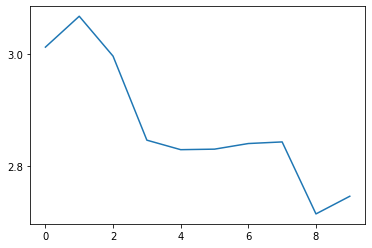

In [29]:
#n_iters是训练集数据的个数，可以小于，但不能大于
#epochs是可调参数，代表训练次数
#n_trains代表第几次训练。
trainIters(encoder1, attn_decoder1, n_iters=len(x_train),epochs=2,print_every=1,plot_every=20,save_every=1,n_trains=1)

In [33]:

#x_test和y_test是测试数据。
#n代表测试多少个测试数据
# res=evaluateRandomly(encoder1, attn_decoder1,x_test,y_test,n=2)
# res,att=evaluate(encoder1,attn_decoder1,x_test)
# print(res)

In [31]:
#测试模型

#读取模型
encoder1=torch.load('model/ecnoder2-1次训练.pkl')
attn_decoder1=torch.load('model/attn_decoder2-1次训练.pkl')

# res=evaluateRandomly(encoder1, attn_decoder1,x_test,y_test,n=1)

#开始测试
for x in range(len(x_test)):
    res,att=evaluate(encoder1,attn_decoder1,x_test[x])
    print(res)#打印预测结果
    for x in y_test[x]:
        note=num_dic[x.item()]
        print(note,end=' ')#打印数据标签
    print('\n')
    print('==='*10)

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'E5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

['<S>', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A5', 'F5', 'A

epoch: 1
iter: 1
input_tensor: torch.Size([432, 1])
target_tensor: torch.Size([12, 1])
0m 0s (- 0m 28s) (1 1%) 2.7001
iter: 2
input_tensor: torch.Size([1200, 1])
target_tensor: torch.Size([30, 1])
0m 1s (- 0m 51s) (2 2%) 2.6616
iter: 3
input_tensor: torch.Size([1037, 1])
target_tensor: torch.Size([26, 1])
0m 1s (- 0m 57s) (3 3%) 2.7694
iter: 4
input_tensor: torch.Size([1203, 1])
target_tensor: torch.Size([30, 1])
0m 2s (- 1m 2s) (4 4%) 2.9880
iter: 5
input_tensor: torch.Size([524, 1])
target_tensor: torch.Size([14, 1])
0m 2s (- 0m 56s) (5 5%) 2.5793
iter: 6
input_tensor: torch.Size([693, 1])
target_tensor: torch.Size([18, 1])
0m 3s (- 0m 53s) (6 6%) 2.4407
iter: 7
input_tensor: torch.Size([692, 1])
target_tensor: torch.Size([18, 1])
0m 3s (- 0m 52s) (7 7%) 2.5581
iter: 8
input_tensor: torch.Size([828, 1])
target_tensor: torch.Size([21, 1])
0m 4s (- 0m 52s) (8 8%) 2.5521
iter: 9
input_tensor: torch.Size([689, 1])
target_tensor: torch.Size([18, 1])
0m 4s (- 0m 50s) (9 9%) 2.6289
iter: 10

0m 43s (- 0m 15s) (73 73%) 2.7152
iter: 74
input_tensor: torch.Size([1289, 1])
target_tensor: torch.Size([32, 1])
0m 43s (- 0m 15s) (74 74%) 2.5268
iter: 75
input_tensor: torch.Size([1080, 1])
target_tensor: torch.Size([27, 1])
0m 44s (- 0m 14s) (75 75%) 2.8801
iter: 76
input_tensor: torch.Size([908, 1])
target_tensor: torch.Size([23, 1])
0m 45s (- 0m 14s) (76 76%) 2.7342
iter: 77
input_tensor: torch.Size([1077, 1])
target_tensor: torch.Size([27, 1])
0m 45s (- 0m 13s) (77 77%) 2.5951
iter: 78
input_tensor: torch.Size([566, 1])
target_tensor: torch.Size([15, 1])
0m 46s (- 0m 13s) (78 78%) 2.5711
iter: 79
input_tensor: torch.Size([1160, 1])
target_tensor: torch.Size([29, 1])
0m 47s (- 0m 12s) (79 79%) 2.9552
iter: 80
input_tensor: torch.Size([479, 1])
target_tensor: torch.Size([13, 1])
0m 47s (- 0m 11s) (80 80%) 2.7054
iter: 81
input_tensor: torch.Size([1261, 1])
target_tensor: torch.Size([31, 1])
0m 48s (- 0m 11s) (81 81%) 2.5484
iter: 82
input_tensor: torch.Size([480, 1])
target_tensor

<Figure size 432x288 with 0 Axes>

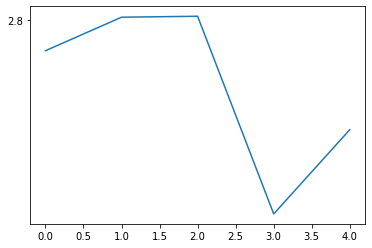

In [32]:
#读取模型继续训练
encoder1=torch.load('model/ecnoder2-1次训练.pkl')
attn_decoder1=torch.load('model/attn_decoder2-1次训练.pkl')
#注意继续训练时，保存模型的名称
trainIters(encoder1, attn_decoder1, n_iters=len(x_train),epochs=1,print_every=1,plot_every=20,save_every=1,n_trains=2)